In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('bmh')
font = {'family' : 'FreeSans',
        'size'   : 14}
matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2)

Read the data

In [2]:
data = pd.read_csv('data/Fire_detector/smoke_detection_iot.csv')

keys = data.keys()
data.drop(columns=keys[0:2], inplace=True)
data.head()
keys = data.keys()

## Exploratory data analysis

See bias:

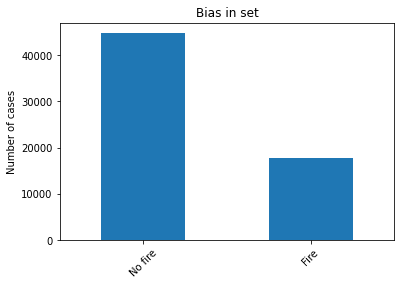

In [3]:
ax = data['Fire Alarm'].value_counts().plot(kind='bar', 
                                            ylabel='Number of cases',
                                            xlabel='',
                                            title='Bias in set')
ax.set_xticks(ticks=(0,1), labels=('No fire', 'Fire'), rotation=45)

Correlation analysis

Text(0, 0.5, 'Correlation')

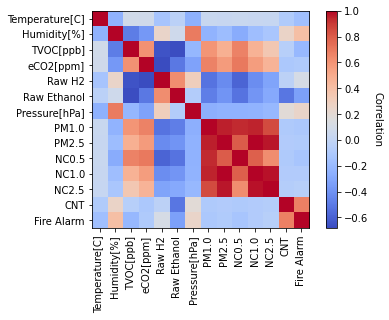

In [4]:
correlation = data.corr()
keys = data.keys()

hm_fig, hm_ax = plt.subplots()
hm_ax.set_xticks(np.arange(len(keys)), labels=keys, rotation=90)
hm_ax.set_yticks(np.arange(len(keys)), labels=keys)
hm_im = plt.imshow(correlation, label=correlation.keys(), cmap='coolwarm')
cbar = hm_ax.figure.colorbar(hm_im, ax=hm_ax)
cbar.ax.set_ylabel('Correlation', rotation=-90, va='bottom')

Drop very correlated variables to avoid multicolinearity effects

In [5]:
data.drop(columns=['PM2.5', 'NC0.5', 'NC1.0', 'NC2.5'], inplace=True)
keys = data.keys()

## Creation of the DL model

Prepare the dataset and dataloader from pytorch.

In [6]:
from torch.utils.data import Dataset, DataLoader

class FireData(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.astype(np.float32)
        self.data = dataframe.drop(columns='Fire Alarm')
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.labels = dataframe['Fire Alarm']
        self.length = self.labels.count()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx].to_numpy())
        y = torch.tensor(self.labels.iloc[idx])
        return x, y
    
    def split(self, frac=1, shuffle=True):
        if shuffle:
            self.dataframe = self.dataframe.sample(frac=1)
        return FireData(self.dataframe.iloc[int(self.length * frac):]), \
               FireData(self.dataframe.iloc[:int(self.length * frac)])
               
    def get_tensors(self):
        x = torch.tensor(self.data.to_numpy())
        y = y = torch.tensor(self.labels.to_numpy())
        return x, y

dataset = FireData(data)
train_dataset, test_dataset = dataset.split(0.9)
test_dataset, val_dataset = test_dataset.split(0.5)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)


Create the model. A simple multilayer perceptron that ends up with a single neuron with range $(0,1)$ indicating the probability of fire. Create the optimizer with the model parameters to optimize.

In [7]:
import torch.nn as nn

class FireDetector(nn.Module):
    def __init__(self, input_size, num_layers, num_features):
        super(FireDetector, self).__init__()
        self.first_layer = nn.Sequential(
            nn.Linear(input_size, num_features),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            *[self.block(num_features) for _ in range(num_layers - 1)]
            )
        self.out = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
    
    def block(self, num_features):
        return nn.Sequential(
            nn.Linear(num_features, num_features),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.first_layer(x)
        x = self.mlp(x)
        x = self.out(x)
        return x

model = FireDetector(len(keys) - 1, 2, 20)
optim = torch.optim.SGD(model.parameters(), lr = 0.01)

print(model)
print(f'Model contains {sum(p.numel() for p in model.parameters())} parameters to optimize')

FireDetector(
  (first_layer): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
  )
  (mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (out): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Model contains 641 parameters to optimize


We use Binary Cross Entropy as loss function for binary classification.

In [8]:
bce = nn.BCELoss()

Create the training loop and train the model

In [9]:
patience = 4
max_epochs = 300

train_losses = []
val_losses = []
stop = False
epoch = 1
while stop is False:
    print(f'In epoch {epoch}.')

    model.train()
    train_loss = 0
    for idx, (X, y) in enumerate(train_dataloader):
        print(f"Data seen {(idx + 1)*X.shape[0]} / {len(train_dataset)}", end='\r', flush=True)
        optim.zero_grad()

        pred = model(X).squeeze()
        loss = bce(pred, y)
        
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        
    train_loss /= (idx + 1)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, (X, y) in enumerate(val_dataloader):
            pred = model(X).squeeze(-1)
            loss = bce(pred, y).item()
            val_loss += loss
            
    val_loss /= (idx + 1)
    val_losses.append(val_loss)

    print(f"\nTrain loss = {train_loss:.2f} | Val loss = {val_loss:.6f}\n")
    
    if epoch > patience:
        check_losses = np.array(val_losses[-patience:])
        if np.argmin(check_losses) == 0 or epoch >= max_epochs: stop = True
    
    epoch += 1

In epoch 1.
Data seen 5390 / 6263
Train loss = 0.70 | Val loss = 0.651108

In epoch 2.
Data seen 5390 / 6263
Train loss = 0.62 | Val loss = 0.581159

In epoch 3.
Data seen 5390 / 6263
Train loss = 0.55 | Val loss = 0.522222

In epoch 4.
Data seen 5390 / 6263
Train loss = 0.50 | Val loss = 0.462884

In epoch 5.
Data seen 5390 / 6263
Train loss = 0.44 | Val loss = 0.403512

In epoch 6.
Data seen 5390 / 6263
Train loss = 0.38 | Val loss = 0.350316

In epoch 7.
Data seen 5390 / 6263
Train loss = 0.33 | Val loss = 0.303976

In epoch 8.
Data seen 5390 / 6263
Train loss = 0.29 | Val loss = 0.264085

In epoch 9.
Data seen 5390 / 6263
Train loss = 0.25 | Val loss = 0.231172

In epoch 10.
Data seen 5390 / 6263
Train loss = 0.22 | Val loss = 0.204613

In epoch 11.
Data seen 5390 / 6263
Train loss = 0.19 | Val loss = 0.182983

In epoch 12.
Data seen 5390 / 6263
Train loss = 0.17 | Val loss = 0.164725

In epoch 13.
Data seen 5390 / 6263
Train loss = 0.15 | Val loss = 0.148672

In epoch 14.
Data see

Let's check how the model behaves for the test set and also print the training curves.

In [42]:
from seaborn import heatmap

def plot_heatmap(confusion, axis):
    heatmap(confusion, annot=True, fmt='d', ax=axis, cmap='viridis')
    axis.set_xticklabels(('Predicted False', 'Predicted True'))
    axis.set_yticklabels(('Actual False', 'Actual True'))

On training set of size 28184 the obtained accuracy is 99.94%


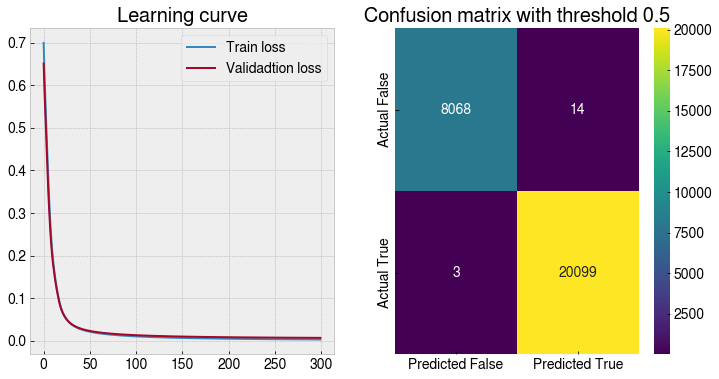

In [56]:
from sklearn.metrics import confusion_matrix, roc_curve

model.eval()
X, y = test_dataset.get_tensors()
with torch.no_grad():
    y_pred = model(X).squeeze().detach()

confusion = confusion_matrix(y, y_pred.round())
total = confusion.sum()
correct = confusion[0,0] + confusion[1,1]
wrong = confusion[0,1] + confusion[1,0]
print(f'On training set of size {total} the obtained accuracy is {correct / total:.2%}')

fig_train, (ax_train, ax_confusion) = plt.subplots(1,2, figsize=(12,6))

ax_train.plot(train_losses, label='Train loss')
ax_train.plot(val_losses, label='Validadtion loss')
ax_train.legend()
ax_train.set_title('Learning curve')

plot_heatmap(confusion, ax_confusion)
ax_confusion.set_title('Confusion matrix with threshold 0.5')

plt.show()

Let's try to minimize at maximum the False Negative cases, since that would mean that we are not detecting a fire. Also, let's visualize how the model predicted all cases. Orange means real fire and purple means real no fire.

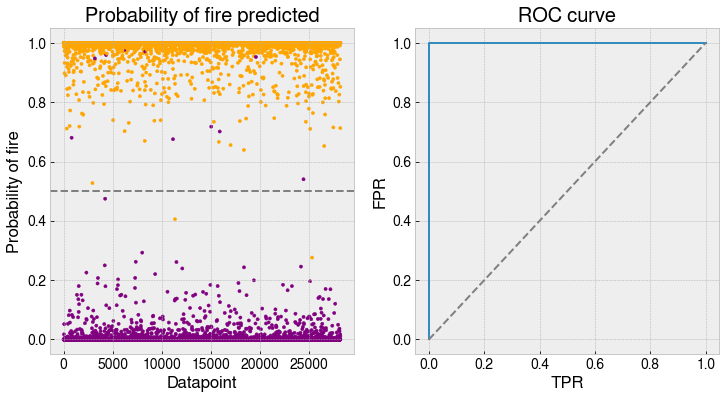

In [35]:
colors = np.where(y == 1, 'orange', 'purple')

fig_ROC, (ax_disp, ax_ROC) = plt.subplots(1, 2, figsize=(12,6))

ax_disp.scatter(np.arange(len(y_pred)), y_pred, color=colors, s=10)
ax_disp.axhline(0.5, ls='--', color='gray')
ax_disp.set_xlabel('Datapoint')
ax_disp.set_ylabel('Probability of fire')
ax_disp.set_title('Probability of fire predicted')

fpr, tpr, _ = roc_curve(y, y_pred)
ax_ROC.plot(fpr, tpr)
ax_ROC.plot(tpr, tpr, ls='--', color='gray')
ax_ROC.set_xlabel('TPR')
ax_ROC.set_ylabel('FPR')
ax_ROC.set_title('ROC curve')

plt.show()

We can see from the probabilities of fire predicted and the ROC curve that the model works pretty well. In order to ensure that no fires are missed, we could choose to use a threshold of 0.20 to diminish the false negatives. Using this threshold, the confusion matrix obtained would be:

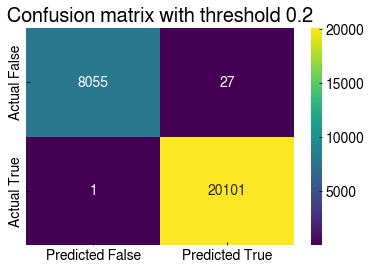

In [55]:
safe_pred = np.where(y_pred > 0.2, 1, 0)

confusion = confusion_matrix(y, safe_pred)

fig_safe, ax_safe = plt.subplots()
plot_heatmap(confusion, ax_safe)
ax_safe.set_title('Confusion matrix with threshold 0.2')

plt.show()